**[<font size=6>💎Diamonds team Y</font>](https://www.kaggle.com/t/73a7efacaa4342bcbe58932e62743ed4)**

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
# !cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 29oct24hse-diamonds      # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

- competition is now set to: 29oct24hse-diamonds
100% 3.30M/3.30M [00:00<00:00, 192MB/s]
Using competition: 29oct24hse-diamonds
  teamId  teamName     submissionDate       score       
--------  -----------  -------------------  ----------  
12874583  A            2024-11-10 18:15:23  465.93895   
12876061  Team K       2024-11-10 18:33:34  512.67258   
12870264  B 🏆💎         2024-11-10 19:45:43  518.40991   
12849475  R_Diamonds   2024-11-10 17:05:25  520.20433   
12862502  F team "F"   2024-11-10 06:52:43  521.27358   
12862711  🏆💎 L         2024-11-10 20:02:53  524.60073   
12865497  J team       2024-11-10 16:54:50  549.82383   
12874408  💎D           2024-11-10 18:41:46  551.81804   
12854107  Team "AI"    2024-11-10 17:58:29  552.49008   
12878798  M Team       2024-11-10 11:55:48  558.73498   
12866121  Q            2024-11-09 13:58:32  559.59905   
12849653  team"T"      2024-11-10 17:33:21  559.72476   
12872141  Team Y       2024-11-10 19:46:10  561.58907   
12850610  W      

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals
os.environ['TF_DETERMINISTIC_OPS'] = '1'; os.environ['TF_CUDNN_DETERMINISTIC'] = '1'; # allows seeding RNG on GPU

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'trainXY/', 'testY/'

CPU times: user 2.87 s, sys: 293 ms, total: 3.16 s
Wall time: 5.39 s


In [ ]:
df = pd.read_csv('XY_diamonds.csv'); df

,carat,depth,table,x,y,z,cut,color,clarity,price
0,0.35,67.2,57.1,4.64,4.69,2.87,I,G,VS1,NaN
1,1.64,67.3,60.7,7.84,7.82,4.94,V,E,SI1,NaN
...,...,...,...,...,...,...,...,...,...,...
199998,0.48,68.7,53.0,4.47,4.45,2.72,I,G,IF,1474.0
199999,0.48,65.0,64.7,5.60,5.62,3.44,I,H,VS2,765.0


In [ ]:
  df.price.info()

<class 'pandas.core.series.Series'>
RangeIndex: 200000 entries, 0 to 199999
Series name: price
Non-Null Count   Dtype  
--------------   -----  
160000 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


In [ ]:
vX = df.query('price!=price').drop('price', axis=1)  # slice a test sample
tXY = df.query('price==price')                       # slice training sample
tX, tY = tXY.drop('price', axis=1), tXY.price        # split into training I/O

In [ ]:
def ScatterCorrHist(df):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000   # marker size
    fsz = abs(corr_r) * 40 + 5 # font size
    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap='coolwarm', vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set(style='white', font_scale=.8);
  g = sns.PairGrid(df, aspect=1, diag_sharey=False);
  g.fig.set_size_inches(20,10)
  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color':'red'}, scatter_kws={'s':1});
  g.map_diag(sns.histplot, kde_kws={'color':'black'});
  g.map_upper(corrdot);
  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();

# ScatterCorrHist(tXY.head(200))  # takes a minute time to run

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

## Импорт библиотек

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np

# Предобработка данных

## Заполнение пропусков и нулевых значений

In [ ]:
df = pd.read_csv('XY_diamonds.csv')

# Замена нулевых значений z на основе данных о глубине бриллианта
df.loc[(df['z'] == 0) & (df['x'] > 0) & (df['y'] > 0), 'z'] = (df['depth'] * (df['x'] + df['y'])) / 2

# Замена нулевых значений x, y, z на основе данных по группам по округленным значениям признаков carat и depth
df['carat_round'] = df['carat'].round(1)
df['depth_round'] = df['depth'].round(0)
group_means = df.groupby(['depth_round', 'carat_round'])[['x', 'y', 'z']].mean().reset_index()
df = pd.merge(df, group_means, on=['depth_round', 'carat_round'], how='left', suffixes=('', '_mean'))
df.loc[(df['x'] == 0) | (df['y'] == 0) | (df['z'] == 0), 'x'] = df['x_mean'].round(3)
df.loc[(df['x'] == 0) | (df['y'] == 0) | (df['z'] == 0), 'y'] = df['y_mean'].round(3)
df.loc[(df['x'] == 0) | (df['y'] == 0) | (df['z'] == 0), 'z'] = df['z_mean'].round(3)

## Кодирование категориальных признаков

In [ ]:
def code(df):
    cut = {"F": 1, "G": 2, "V": 3, "P": 4, "I": 5}
    clarity = {"I1": 1, "SI2": 2, "SI1": 3, "VS2": 4, "VS1": 5, "VVS2": 6, "VVS1": 7, "IF": 8}
    color = {"J": 1, "I": 2, "H": 3, "G": 4, "F": 5, "E": 6, "D": 7}
    df['cut'] = df['cut'].map(cut)
    df['clarity'] = df['clarity'].map(clarity)
    df['color'] = df['color'].map(color)
    return df

df = code(df)

## Создание новых признаков

In [ ]:
def new_features(df):
    df['volume'] = df['x'] * df['y'] * df['z']
    df['surf_area'] = df['x'] * df['y']
    return df

df = new_features(df)

## Логарифмическое преобразование некоторых признаков  

In [ ]:
def non_linear_feats(df):
    non_linear_feat = ['carat', 'x', 'y', 'z']
    df[non_linear_feat] = np.log1p(df[non_linear_feat])
    return df

df = non_linear_feats(df)

## Создание полиномиальных признаков

In [ ]:
def create_poly_feats(df):
    y = df['price']
    X = df.drop(columns=['price', 'x_mean', 'y_mean', 'z_mean'])
    poly = PolynomialFeatures(degree=3, include_bias=False)
    X_poly = poly.fit_transform(X)
    features = poly.get_feature_names_out(input_features=X.columns)
    X = pd.DataFrame(X_poly, columns=features)
    df = pd.concat([X, y.reset_index(drop=True)], axis=1)
    return df

df = create_poly_feats(df)

## Масштабирование признаков с помощью StandardScaler

In [ ]:
def scale(df):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df.drop(columns=['price']))
    feature_names = df.drop(columns=['price']).columns
    X = pd.DataFrame(X_scaled, columns=feature_names)
    df = pd.concat([X, df['price'].reset_index(drop=True)], axis=1)
    return df

df = scale(df)

# Обучение модели

## Выбор количества кластеров

In [ ]:
# Выполнить только 1 раз, так как очень долго выполняется и сказывается на финальном времени в TGP.

# total = list(range(1, 51))
# sse = []

# for i in total:
#     kmeans = MiniBatchKMeans(n_clusters=i, random_state=0, batch_size=100)
#     kmeans.fit(df.drop(columns=['price']))
#     sse.append(kmeans.inertia_)

# plt.plot(total, sse, marker='o')
# plt.xlabel('Количество кластеров')
# plt.ylabel('SSE')
# plt.title('Метод локтя')

# # выбранное количество кластеров - 20

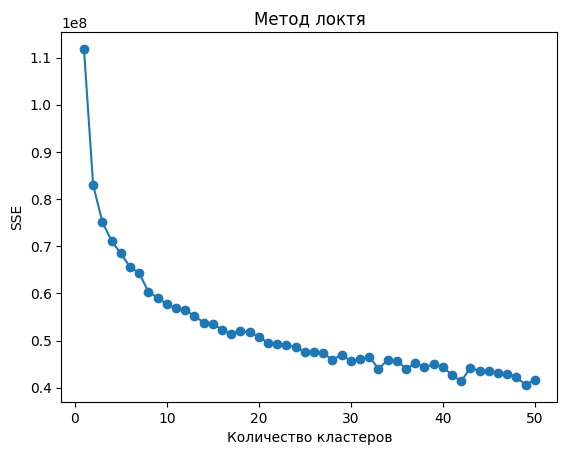

## Обучение модели

In [ ]:
def train_models(df, num_clusters=20):
    train = df.query('price == price').copy()
    train_X, train_Y = train.drop('price', axis=1), train['price']

    X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.2, random_state=32)

    # Кластеризация
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=100)
    train_clusters = kmeans.fit_predict(X_train)
    test_clusters = kmeans.predict(X_test)

    # Настройка гиперпараметров
    params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]}
    models = {}
    params_list = []
    for i in range(num_clusters):
        cluster_X = X_train[train_clusters == i]
        cluster_Y = y_train[train_clusters == i]

        ridge = Ridge()

        search = GridSearchCV(ridge, params, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
        search.fit(cluster_X, cluster_Y)

        best = search.best_estimator_
        params_list.append(best.coef_[0])

        models[i] = best

    y_pred_test = np.zeros(len(X_test))
    for i in range(num_clusters):
        cluster_ind = np.where(test_clusters == i)[0]
        if len(cluster_ind) > 0:
            cluster_X = X_test.iloc[cluster_ind]
            y_pred_test[cluster_ind] = models[i].predict(cluster_X)

    return models, y_pred_test, kmeans

models, y_pred_test, kmeans = train_models(df)

In [ ]:
def predictions(df, models, kmeans, n_clusters=20):
    predict_df = df.query('price != price').copy()
    predict_X = predict_df.drop('price', axis=1)
    predict_clusters = kmeans.predict(predict_X)
    y_pred_all = np.zeros(len(predict_X))
    for i in range(n_clusters):
        cluster_indices = np.where(predict_clusters == i)[0]
        if len(cluster_indices) > 0:
            cluster_X = predict_X.iloc[cluster_indices]
            y_pred_all[cluster_indices] = models[i].predict(cluster_X)

    y_pred_all = np.clip(y_pred_all, a_min=0, a_max=None)

    return y_pred_all.flatten()

preds = predictions(df, models, kmeans)
predict_ids = df[df['price'].isna()].index + 1
res = pd.DataFrame({
    'id': predict_ids,
    'price': preds
})
res.to_csv('result.csv', index=False)

<font color=green><h3><b>$\epsilon$. Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Explain Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.</font>

<font color=green>

1. Why did you choose these elements? (Something in EDA, prior experience,...? Note: EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

Для работы в Google Collab использовали аппаратный ускоритель TPU v2-8, так как он обеспечивал лучшую скорость исполнения кода. Финальное тестирование кода осуществляли на стандартном ускорителе, так как закончился лимит по использованию TPU v2-8.

Если возникнут какие-либо технические проблемы, просим написать в tg - @wearyhead





# Предобработка данных

## Заполнение пропусков и нулевых значений

В рамках разведочного анализа данных были выявлены нереалистичные значения в полях, описывающих размер камней: x, y, z. Данные аномалии можно разделить на две части:
- Недостает 2 или 3 значений
- Недостает только 1 значения (такие случаи связаны исключительно с атрибутом z)

Чтобы избавиться от данной проблемы мы производим следующие действия:
- Сперва устраняем пустоты, основываясь на том, что атрибут depth рассчитывается на базе всех трех атрибутов и его формула нам известна ($\text{depth} = \frac{z}{\text{mean}(x, y)} = \frac{2 \cdot z}{x + y}$): выводим формулу z и рассчитываем значения атрибутов для объекта
- Устраняем пустоты основываясь на атрибутах carat и depth, которые отражают вес и размер камня: для каждой каратности и глубины (предварительно сгруппировав, уменьшив точность значений) рассчитываем средние величины камней, у которых они известны.

## Кодирование категориальных признаков

Так как модели линейных регрессий работают с числовыми атрибутами, мы перевели категориальные признаки в набор упорядоченных чисел (выполнили кодирование категориальных признаков):
- Cut (Fair = 1, Good = 2, Very Good = 3, Premium = 4, Ideal = 5);
- Clarity (I1 (worst) = 1, SI2 = 2, SI1 = 3, VS2 = 4, VS1 = 5, VVS2 = 6, VVS1 = 7, IF (best) = 8);
- Color (J = 1, I = 2, H = 3, G = 4, F = 5, E = 6, D = 7).


![Alt Text](https://avatars.mds.yandex.net/i?id=0e07f33df93f89c522f11916aa80a0ff_l-5132176-images-thumbs&n=13)


## Создание новых признаков


На основе имеющихся признаков x, y, z создали новые признаки - объем алмаза (volume) и признак произведения ширины и длины (surf_area).
Данные признаки позволили модели уловить дополнительные детали о размере и форме алмаза, что положительно сказалось на метрике МАЕ.

P.S. пробовали создавать множество других признаков, но они перегружали модель. Оставили только самые значимые признаки.


## Логарифмическое преобразование некоторых признаков

Посмотрели графики распределения всех имеющихся признаков. Отобрали признаки, которые смещены влево и не имеют нормальное распределение - carat, x, y, z. Выполнили логарифмическое преобразование этих признаков для нормализации распределений.

## Создание полиномиальных признаков

Для того, чтобы учесть нелинейные взаимосвязи между признаками создали полиномиальные признаки. Путем итеративного подхода выбрали степень полинома = 3, что позволило добавить модели сложность, но при этом не перегрузить модель.

## Выбор количества кластеров

C помощью метода локтя выбрали оптимальное количество кластеров = 20.

В целях оптимизации скорости обучения и точности вывода модели определяли важность признаков и отбрасывали наиболее неважные, это ускорило обучение, но слегка понизило точность предсказаний.


<font color=green><h4><b>Task 2. Explain Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

# Обучение модели

## Обучение модели для каждого кластера


- Выполнили фильтрацию данных, чтобы оставить только строки с известной ценой (price), поскольку только на этих данных можно обучать модель.
- Разделили данные на признаки и целевую переменную: выделили все столбцы, кроме price, в train_X и сами цены в train_Y.
- Разбили данные на обучающую и тестовую выборки с помощью train_test_split, чтобы оценивать модель на тестовых данных и проверять её точность на ранее не виденных данных.  
- Выполнили кластеризацию с MiniBatchKMeans на обучающей выборке, чтобы разбить данные на группы (кластеры), в которых объекты будут более похожи друг на друга. Для кластеризации использовали алгоритм KMeans и MiniBatchKMeans. MiniBatchKMeans показал наилучший результат по скорости выполнения кода, поэтому выбрали MiniBatchKMeans.
- Выбрали диапазоны для альфы для нашей модели Ridge с использованием GridSearchCV для поиска оптимального значения альфа.
- Создали и обучили модель Ridge для каждого кластера, при этом:
  - выбрали необходимые данные из обучающей выборки, относящиеся к текущему кластеру.
  - применили GridSearchCV, чтобы подобрать наилучшее значение альфы для каждого кластера.
  - и сохранили полученную на шаге 2 модель с оптимальной альфой для каждого кластера в словарь models.

Подбирали гиперпараметры для Ridge, но остановились на подборе только альфы, так как подбор других гиперпараметров очень сильно замедлял обучение модели.

Помимо модели Ridge пробовали другие линейные модели, такие как: Lasso, ElasticNet, Classic Linear Regression, но данные модели показали меньшую точность предсказания, поэтому остановили свой выбор на Ridge.

Вместо StandardScaler пробовали применять MinMaxScaler и Normalizer, но StandardScaler показал лучшую скорость и точность.



<font color=green><h3><b>$\zeta$. References</b></h3></font>

<font color=green>
Cite your sources to help your peers learn from these (and to avoid plagiarism claims). At the least, ISLP textbook should be cited. Use Google Scholar to draw APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources.

1. [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)
2. [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
3. [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
4. [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
5. Использование PolynomialFeatures (страница 90 ISLR)
> "As discussed previously, the linear regression model (3.19) assumes a linear
 relationship between the response and predictors. But in some cases, the
 true relationship between the response and the predictors may be non
linear. Here we present a very simple way to directly extend the linear model
 to accommodate non-linear relationships, using polynomial regression."

6. Замена отсутствующих значений ([Статья "Предварительная обработка данных для машинного обучения"](https://science-engineering.ru/ru/article/view?id=1391))
> "Методы интерполяции пропущенных значений для построения данных.
К первым относятся средняя интерполяция, прямая или обратная интерполяция и методы скользящего среднего. В этом случае недостающие значения выводятся на основе характеристик данных только одной переменной и поэтому называются одномерными методами. Метод интерполяции среднего или медианы заменяет недостающие значения средним или медианой этой переменной. Прямой или обратный метод просто заменяет отсутствующее значение предыдущим или следующим измерением данных. Эти два метода просты в реализации, но не учитывают временные корреляции на временных этапах и могут не сделать правильную замену данных."

7. Применение логарифмической трансформации ([Статья "Введение в Feature Engineering для начинающих дата-сайентистов и ML-инженеров"](https://habr.com/ru/companies/skillfactory/articles/842444/))
> Логарифмическая трансформация: применяется для признаков с сильно скошенным распределением, где существует длинный хвост справа (например, доходы, цены), чтобы сделать данные более симметричными.

8. Использование Mini-batch K-means ([Яндекс хэндбук - Кластеризация](https://education.yandex.ru/handbook/ml/article/klasterizaciya))
> Несложно заметить, что, если считать K и размерность пространства признаков константами, оба шага алгоритма работают за O(n), где n — количество объектов обучающей выборки. Отсюда возникает идея ускорения работы алгоритма. В mini-batch K-means мы не считаем шаги сразу на всей выборке, а на каждой итерации выбираем случайную подвыборку (мини-батч) и работаем на ней. В случае когда исходная выборка очень велика, переход к пакетной обработке не приводит к большой потере качества, зато значительно ускоряет работу алгоритма.

9. Подбор гиперпараметров с помощью GridSearchCV ([Статья "Введение в Feature Engineering для начинающих дата-сайентистов и ML-инженеров"](https://habr.com/ru/companies/skillfactory/articles/842444/))
> Один из наиболее распространенных способов настройки гиперпараметров — это решетчатый подход. Этот метод предполагает задание наборов значений для каждого гиперпараметра, которые затем "перебираются" систематически для нахождения наилучшей комбинации. Для каждой комбинации гиперпараметров производится обучение модели и оценка её производительности на валидационных данных.

10. Использование StandardScaler ([Статья про преобразование данных](https://www.dmitrymakarov.ru/data-analysis/transform-08/))
> Если данные следуют нормальному или близкому к нормальному распределению (что желательно для многих моделей ML), имеет смысл прибегнуть к стандартизации (standartazation): то есть приведению к нулевому среднему значению и единичному СКО (так называемое стандартное нормальное распределение).












## Выводы

С помощью линейной регрессии с подобранными гиперпараметрами и предварительной кластеризацией кристаллов удалось снизить значение MAE до 558.47 на тестовых данных

Из того, что можно было бы улучшить:
1. подобрать гиперпараметры для моделей регрессии помимо значения alpha, такие как: solver и tol
2. разобраться, в чем причина высокого значения МАЕ на некоторых кластерах и сделать корректировку
3. попробовать использовать модели на основе решающих деревьев, такие, как, например, случайные леса и бустинг

<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 281 sec > 60 sec limit!!!


Для работы в Google Collab использовали аппаратный ускоритель TPU v2-8, так как он обеспечивал лучшую скорость исполнения кода (**менее 60 секунд**). Финальное тестирование кода осуществляли на стандартном ускорителе, так как закончился лимит по использованию TPU v2-8.

Если возникнут какие-либо технические проблемы, просим написать в tg - @wearyhead
